In [5]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import image_masking as im
import importlib
import pyspark

## Initializing Spark session and loading data

In [10]:
conf = pyspark.SparkConf().setMaster("local[2]").setAppName("loading").set('spark.jars', '../scifio-spark-datasource-uber.jar')
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=loading, master=local[2]) created by __init__ at c:\Users\Jonathan\Documents\Informatica\Big Data\big-data-science-project\image_segmentation\image_masking.py:15 

In [189]:
path = '../data/'
fileLimit = 2
channel = 3

In [190]:
df = im.load_dataframe(spark, path, fileLimit)

## Load image

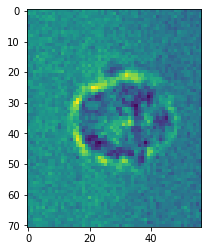

In [191]:
import matplotlib.pyplot as plt
row = df.take(1)[0]
cell = im.row_to_image(row, channel)
plt.imshow(image)
image_df = im.image_to_df(cell, spark)

## KMeans Clustering

In [9]:
from pyspark.ml.clustering import KMeans

In [10]:
kmeans = KMeans(k=2)
kmeans.setSeed(1)
kmeans.setMaxIter(10)

kmeans.setWeightCol("weighCol")

KMeans_13d5a7bb4e7c

In [11]:
model = kmeans.fit(image_df)
model.setPredictionCol("newPrediction")

KMeansModel: uid=KMeans_13d5a7bb4e7c, k=2, distanceMeasure=euclidean, numFeatures=3

In [12]:
transformed = model.transform(image_df).select("features", "newPrediction")
rows = transformed.collect()

In [13]:
import numpy as np
pred_mask = np.reshape([r.newPrediction for r in rows], (row.width,row.height))

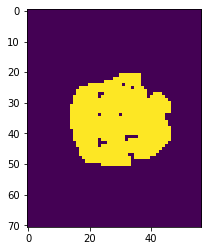

In [14]:
plt.imshow(im.row_to_mask(row, channel))

In [16]:
opened_mask = im.apply_opening(pred_mask)

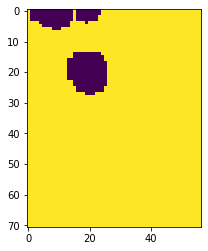

In [17]:
plt.imshow(opened_mask)

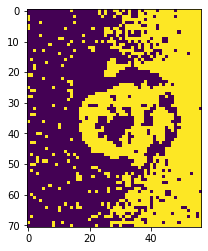

In [18]:
plt.imshow(pred_mask)

In [19]:
accuracy = (im.row_to_mask(row) == opened_mask).mean()
accuracy

0.08673091178650852

## DBSCAN Clustering

In [43]:
from sklearn.cluster import DBSCAN

In [44]:
image_features = np.array([[p] for index, p in np.ndenumerate(image)])

In [45]:
clustering = DBSCAN(eps=2.5, min_samples=1).fit(image_features)

In [46]:
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [47]:
clustering_image = np.reshape(clustering.labels_, image.shape)

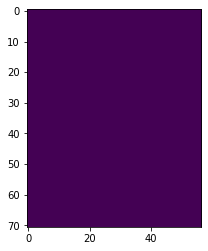

In [48]:
plt.imshow(clustering_image)

## Hough Transform

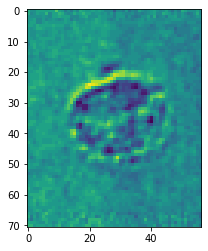

In [346]:
channel = 6
row = df.take(2)[0]
cell = im.row_to_image(row, channel)
plt.imshow(cell)

In [347]:
import cv2 as cv
cell = cell.astype('uint8')

In [348]:
cell_blurred = cv.medianBlur(cell, 5)

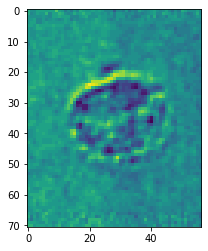

In [349]:
plt.imshow(cell)

In [350]:
edges = cv.Canny(cell_blurred,10,20)

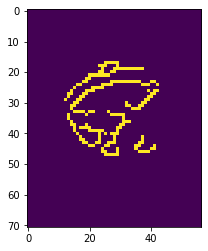

In [351]:
plt.imshow(edges)

In [352]:
opened_mask = im.apply_opening(edges)

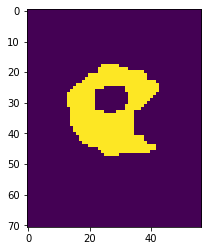

In [353]:
plt.imshow(opened_mask)

In [356]:
rows = df.take(10)

In [409]:
channel = 6

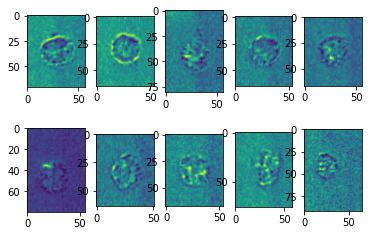

In [410]:
width = 5
height = 2
f, axarr = plt.subplots(height, width)
for i in range(height):
    for j in range(width):
        cell = im.row_to_image(rows[i*width + j], channel)
        axarr[i, j].imshow(cell)

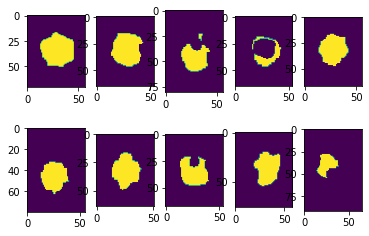

In [414]:
width = 5
height = 2
f, axarr = plt.subplots(height, width)
for i in range(height):
    for j in range(width):
        cell = im.row_to_image(rows[i*width + j], channel)
        cell = cell.astype("uint8")
        edges = cv.Canny(cell,20,40)
        opened_mask = im.apply_opening(edges)
        axarr[i, j].imshow(opened_mask)

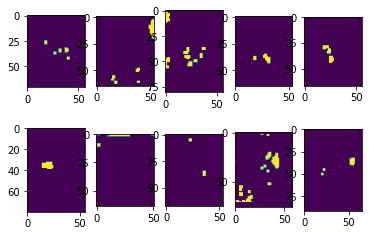

In [415]:
width = 5
height = 2
f, axarr = plt.subplots(height, width)
for i in range(height):
    for j in range(width):
        mask = im.row_to_mask(rows[i*width + j], channel)
        axarr[i, j].imshow(mask)